In [312]:
%load_ext autoreload

%autoreload 2

import tools as t
import readdata as rm
import predictive_model as m
import evaluate as e

from lentil import models
from lentil import evaluate
from lentil import datatools

import pandas as pd
import numpy as np
import pickle
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read Raw Data and Generate Features into 'processed_data.txt'

In [108]:
rm.getTrainingInstances('raw_data/spanish_data.csv','spanish_processed.txt', 0, 2, 1, 3)

reading data
finished initial process
getting features
writing data...


In [123]:
rm.getTrainingInstances('raw_data/radical_transfer_2007.csv','radical_processed.txt', 0, 3, 2, 4)

reading data
finished initial process
getting features
writing data...


In [3]:
rm.getTrainingInstances('raw_data/chinese-hundredthousand.csv','chinese_processed.txt', 0, 3, 2, 4, 'pickles/history.pkl')

getting features
writing data...


Convert processed data into Interaction History object

In [109]:
spanish_history = t.textToInteractionHistory('spanish_processed.txt', 'timestamp', 'student_id','module_id','outcome', 'True')

filtered_spanish = t.filterHistory(spanish_history.data)

In [42]:
radical_history = t.textToInteractionHistory('radical_processed.txt', 'timestamp', 'student_id','module_id','outcome', 'True')

filtered_radical = t.filterHistory(radical_history.data)

KeyboardInterrupt: 

In [8]:
chinese_history = t.textToInteractionHistory('chinese_processed.txt', 'timestamp', 'student_id','module_id','outcome', 'True')

filtered_chinese = t.filterHistory(chinese_history.data)

0 out of 79119
100 out of 79119
200 out of 79119
300 out of 79119
400 out of 79119
500 out of 79119
600 out of 79119
700 out of 79119
800 out of 79119
900 out of 79119
1000 out of 79119
1100 out of 79119
1200 out of 79119
1300 out of 79119
1400 out of 79119
1500 out of 79119
1600 out of 79119
1700 out of 79119
1800 out of 79119
1900 out of 79119
2000 out of 79119
2100 out of 79119
2200 out of 79119
2300 out of 79119
2400 out of 79119
2500 out of 79119
2600 out of 79119
2700 out of 79119
2800 out of 79119
2900 out of 79119
3000 out of 79119
3100 out of 79119
3200 out of 79119
3300 out of 79119
3400 out of 79119
3500 out of 79119
3600 out of 79119
3700 out of 79119
3800 out of 79119
3900 out of 79119
4000 out of 79119
4100 out of 79119
4200 out of 79119
4300 out of 79119
4400 out of 79119
4500 out of 79119
4600 out of 79119
4700 out of 79119
4800 out of 79119
4900 out of 79119
5000 out of 79119
5100 out of 79119
5200 out of 79119
5300 out of 79119
5400 out of 79119
5500 out of 79119
5600

Training EFC Model

In [35]:
efc_model = e.train_efc(chinese_history.data, filtered_chinese.data)

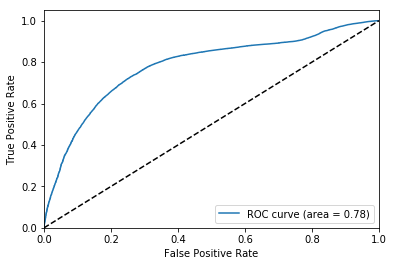

0.78138144771997342

In [36]:
evaluate.training_auc(efc_model, filtered_chinese)

Training Logistic Model

In [31]:
logistic_model = e.train_logistic(chinese_history.data, filtered_chinese.data)

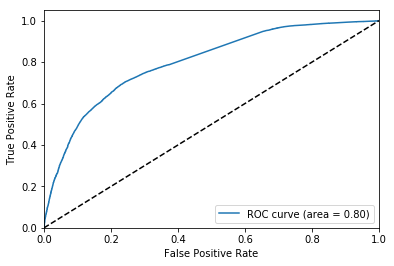

0.79837878930544948

In [38]:
evaluate.training_auc(logistic_model, filtered_chinese)

Training OnePL Model 

In [ ]:
onepl_model = e.train_onepl(chinese_history.data, filtered_chinese.data)

In [ ]:
evaluate.training_auc(onepl_model, filtered_chinese)

Evaluate Models

In [27]:
results = e.getResults(filtered_chinese, 4, False)

In [39]:
e.overallAccuracy(['EFC', '1PL IRT', 'LR'], results)

 EFC: 0.79101089098 1PL IRT: 0.84077907452 LR: 0.81125583237
 EFC: 0.694927536232 1PL IRT: 0.796688808374 LR: 0.738586956522


Online Prediction Accuracy: Spanish, Radical and Chinese Datasets

Training population: 20%; Testing population: 80%

In [269]:
#split history
train_chinese, test_chinese = t.splitHistory(filtered_chinese)

In [278]:
#Testing
raw_modules = list(filtered_chinese.data['module_id'].drop_duplicates())
modules = [int(i) for i in raw_modules]
modules.sort()

raw_students = list(filtered_chinese.data['student_id'].drop_duplicates())
students = [int(i) for i in raw_students]
students.sort()

In [335]:
#train model
onepl_model = e.train_onepl(filtered_chinese.data, filtered_chinese.data)
initial_difficulties = e.getIRTParameters(onepl_model)[1]

In [339]:
test_students = test_chinese._student_idx
test_modules = filtered_chinese._assessment_idx

In [340]:
correct = 0
wrong = 0

for i in range(test_chinese.num_students()-1):
    def getCurrentStudent(index):
        return test_students.keys()[test_students.values().index(index)]
    
    current_student_history = test_chinese.data[test_chinese.data['student_id'] == getCurrentStudent(i)]
    print 'current student: ' + getCurrentStudent(i) + ', with ' + str(len(current_student_history)) +' interactions.'
    if i > 0:
        print float(correct)/(float(correct)+float(wrong))
    
    for x in range(len(current_student_history)):
        
        prob = 0
        if x < 2:
            prob = 0
        else:
            df = pd.concat([train_chinese.data, current_student_history[0:x]])
            onepl_model = e.train_onepl(None, df)            
            difficulty = initial_difficulties[test_modules[current_student_history.iloc[x]['module_id']]]
            
            student_ids = onepl_model.idx_of_student_id
            ability = e.getIRTParameters(onepl_model)[0][student_ids[getCurrentStudent(i)]]
            prob = 1 / (1 + math.exp(-(ability + difficulty)))
        if round(prob) == current_student_history.iloc[x]['outcome']:
            correct += 1
        else: 
            wrong += 1    
#             print 'Student: ' + getCurrentStudent(i) + ', item: ' + str(test_modules[current_student_history.iloc[x]['module_id']]) + ';' + str(prob)
            
        

current student: 21, with 570 interactions.
current student: 22, with 601 interactions.
0.850877192982
current student: 24, with 1116 interactions.
0.866780529462
current student: 26, with 318 interactions.
0.886313948404
current student: 27, with 999 interactions.
0.894817658349
current student: 28, with 703 interactions.
0.914539400666
current student: 29, with 158 interactions.
0.915718597632
current student: 30, with 443 interactions.
0.91444568869
current student: 31, with 281 interactions.
0.901792991035
current student: 32, with 262 interactions.
0.895548275198
current student: 33, with 1230 interactions.
0.897450009173
current student: 35, with 221 interactions.
0.887741356084
current student: 36, with 386 interactions.
0.888148362793
current student: 37, with 731 interactions.
0.879527991218
current student: 38, with 322 interactions.
0.879037286445
current student: 39, with 172 interactions.
0.871718019422
current student: 40, with 1146 interactions.
0.867614237049
current st

KeyboardInterrupt: 